# Poisson equation

A "Hello World" example for any FEM software is to solve the equation
$$
\begin{aligned}
-\Delta u &= f, \quad \text{in} \quad \Omega \subset \mathbb R^2,\\
u &= 0, \quad \text{on} \quad \Gamma_D.
\end{aligned}
$$

We can formulate this problem as: find $u \in H^1_0(\Omega)$ that
$$
\min \limits_{u \in H^1_0(\Omega)} \left\{ \frac 12 \int_\Omega |\nabla u|^2 \, \mathrm dx - \int_\Omega f u \, \mathrm dx \right\}.
$$

Indeed, the minimum is achieved for $u$ for which
$$
a(u, v) = L(v), \quad \forall v \in H^1_0(\Omega)
$$
with
$$
\begin{aligned}
a(u, v) = \int_\Omega \nabla u \cdot \nabla v \, \mathrm dx, \quad L(v)    = \int_\Omega f v \, \mathrm dx.
\end{aligned}
$$
which can by found by the variation of the above functional. The space $H^1_0(\Omega)$ are all $H^1(\Omega)$ functions that vanish on Dirichlet part of the boundary, $\Gamma_D$.

Once discretized using a conforming choice $V_h \subset H^1_0(\Omega)$, the problem of minimizing the above reduces to
$$
\min\limits_{\bm x \in \mathbb R^n} \left\{ \bm x \cdot \bm A \bm x - \bm b \cdot \bm x \right\}
$$
which is a convex, quadratic and unconstrained minimization problem (special case of Quadratic Programming, QP) for which solution can be found in a closed form (single matrix inversion). Stiffness matrix $\bm A \in \mathbb R^{n \times n}$ and vector $\bm b \in \mathbb R^n$
$$
A_{ij} = \int_\Omega \nabla \varphi_i \cdot \nabla \varphi_j \, \mathrm dx, \quad b_i = \int_\Omega f \varphi_i \, \mathrm dx
$$
where $\varphi_i$ are basis functions of the space $V_h$.

In [14]:
import dolfinx
import dolfinx.plot
import ufl
from mpi4py import MPI
import pyvista as pv
import os
import numpy as np

A simple 2D L-shape mesh could be easily generated using [GMSH](https://gmsh.info/). This example is using native GMSH geometry kernel, so we build the geometry from lower to higher dimension (from points to lines, surfaces and volumes).

GMSH supports also OpenCASCADE (OCC) kernel, so a geometry could be created with OCC primitives. Alternatively, we can import some of the standard geometry files as STEP, IGES or OCC BREP. GMSH also provides a graphical interface that we can use to visualize the geometry and inspect line, surface and volume IDs.

<div align="center"><img src="images/gmsh.png" alt="pyvista" width="700"/></div>

In [31]:
mesh_size = 0.04
width = 1.0
height = 1.0
scale = 3

import gmsh
if not gmsh.is_initialized():
    gmsh.initialize()
gmsh.clear()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.option.setNumber("Mesh.MeshSizeMax", mesh_size)

p0 = gmsh.model.geo.addPoint(0.0, 0.0, 0.0)
p1 = gmsh.model.geo.addPoint(width, 0.0, 0.0)
p2 = gmsh.model.geo.addPoint(width, height / scale, 0.0)
p3 = gmsh.model.geo.addPoint(width / scale, height / scale, 0.0)
p4 = gmsh.model.geo.addPoint(width / scale, height, 0.0)
p5 = gmsh.model.geo.addPoint(0.0, height, 0.0)

l0 = gmsh.model.geo.addLine(p0, p1)
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p5)
l5 = gmsh.model.geo.addLine(p5, p0)

cl = gmsh.model.geo.addCurveLoop([l0, l1, l2, l3, l4, l5])
ps = gmsh.model.geo.addPlaneSurface([cl])

gmsh.model.geo.synchronize()

gmsh.model.addPhysicalGroup(2, [ps], tag=1)
gmsh.model.addPhysicalGroup(1, [l0, l1, l2, l3, l4, l5], tag=2)

# Generate the mesh
gmsh.model.mesh.generate()
gmsh.write('l-shape.geo_unrolled')

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.000565875s, CPU 0.000779s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00763467s, CPU 0.007038s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 6.7333e-05s, CPU 9.6e-05s)
Info    : 486 nodes 976 elements
Info    : Writing 'l-shape.geo_unrolled'...


Info    : Done writing 'l-shape.geo_unrolled'


Dolfinx provides a helper function `dolfinx.io.gmshio.model_to_gmsh` that converts the GMSH model/mesh into a `dolfinx.mesh.Mesh` object along with `dolfinx.mesh.MeshTags` that store tagged mesh cells or facets.

In [32]:
mesh, cell_tags, facet_tags = dolfinx.io.gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, rank=0, gdim=2)
boundary_facets = facet_tags.indices[facet_tags.values == 2]
print(f"Number of boundary facets: {len(boundary_facets)}")

Number of boundary facets: 102


In addition, there is `dolfinx.plot.vtk_mesh` to help with converting the internal dolfinx Mesh into primite arrays useful for visualization.

A powerful and interactive visualization tool based on VTK is [PyVista](https://docs.pyvista.org/),

<div align="center"><img src="images/pyvista.png" alt="pyvista" width="600"/></div>

In [33]:
import os
os.environ["LIBGL_ALWAYS_SOFTWARE"] = "1"
pv.set_jupyter_backend("html")
pv.start_xvfb()

pv.global_theme.window_size = [600, 500]

In [34]:
cells, types, x = dolfinx.plot.vtk_mesh(mesh)
grid = pv.UnstructuredGrid(cells, types, x)

plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True, lighting=False)
plotter.camera_position = "xy"
plotter.enable_parallel_projection()
plotter.show_axes()
plotter.show_grid()
plotter.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

With the mesh ready, lets setup function spaces. We choose a conforming discretization $P_1 \subset H^1(\Omega)$ with $P_1$ being the standard piecewise linear, globally continuous space (Lagrange degree 1), see [defelement.org](https://defelement.org/elements/examples/triangle-lagrange-equispaced-1.html),

<div align="center"><img src="images/p1.png" alt="lagrange-p1" width="600"/></div>

Dolfinx implicitly calls the `basix` library to provide information about connectivity of the element degrees-of-freedom, their numbering, element pullback, element interpolation matrix and many others.

In [35]:
V = dolfinx.fem.functionspace(mesh, ("P", 1))
print(f"Number of degrees of freedom: {V.dofmap.index_map.size_global}")

Number of degrees of freedom: 486


In [36]:
basis0 = dolfinx.fem.Function(V)
basis0.x.array[10] = 1.0

cells, types, x = dolfinx.plot.vtk_mesh(V)
grid = pv.UnstructuredGrid(cells, types, x)

grid.point_data["u"] = basis0.x.array
grid.set_active_scalars("u")
grid_warped = grid.warp_by_scalar("u", factor=0.2)
grid_warped = grid_warped.tessellate()

plotter = pv.Plotter()
plotter.add_mesh(grid_warped, show_edges=True, lighting=False)
plotter.camera_position = "xy"
plotter.enable_parallel_projection()
plotter.show_axes()
plotter.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [37]:

u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = dolfinx.fem.Constant(mesh, 20.0)
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

In [38]:
boundary_dofs = dolfinx.fem.locate_dofs_topological(V, entity_dim=1, entities=boundary_facets)
bc = dolfinx.fem.dirichletbc(dolfinx.fem.Constant(mesh, 0.0), dofs=boundary_dofs, V=V)

In [39]:

import dolfinx.fem.petsc
problem = dolfinx.fem.petsc.LinearProblem(a, L, bcs=[bc],
                                          petsc_options={"ksp_type": "preonly",
                                                         "pc_type": "cholesky"})
uh = problem.solve()

In [47]:
cells, types, x = dolfinx.plot.vtk_mesh(V)
grid = pv.UnstructuredGrid(cells, types, x)

grid.point_data["u"] = uh.x.array
grid.set_active_scalars("u")
grid_warped = grid.warp_by_scalar("u")
grid_warped = grid_warped.tessellate()

plotter = pv.Plotter()
plotter.add_mesh(grid_warped, show_edges=True, ambient=0.5, specular=0.2, n_colors=10)
plotter.camera_position = "xy"
plotter.enable_parallel_projection()
plotter.show_axes()
plotter.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

### Inspection of the underlying linear algebra objects

Even though `dolfinx` is agnostic to the use of linear algebra backend and it has its own distributed CSR matrix class, we've explicitly used the `LinearProblem` class from `petsc` namespace.

For more involved formats and solvers we recommend to use [PETSc](https://petsc.org/) which builds on a very powerful abstraction of Krylov solvers (KSP) and preconditioners (PC). See [PETSc manual](https://petsc.org/release/manual/manual.pdf).

<div align="center"><img src="images/petsc.png" alt="PETSc and TAO" height="80"/></div>




In [41]:
problem.solver.view()

KSP Object: (dolfinx_solve_281472314478848) 1 MPI process
  type: preonly
  maximum iterations=10000, initial guess is zero
  tolerances: relative=1e-05, absolute=1e-50, divergence=10000.
  left preconditioning
  using NONE norm type for convergence test
PC Object: (dolfinx_solve_281472314478848) 1 MPI process
  type: cholesky
    out-of-place factorization
    tolerance for zero pivot 2.22045e-14
    matrix ordering: nd
    factor fill ratio given 5., needed 3.4981
      Factored matrix follows:
        Mat Object: (dolfinx_solve_281472314478848) 1 MPI process
          type: seqsbaij
          rows=486, cols=486
          package used to perform factorization: petsc
          total: nonzeros=6433, allocated nonzeros=6433
              block size is 1
  linear system matrix = precond matrix:
  Mat Object: (dolfinx_solve_281472314478848) 1 MPI process
    type: seqaij
    rows=486, cols=486
    total: nonzeros=3192, allocated nonzeros=3192
    total number of mallocs used during MatSet

System matrix could be simply extracted and converted into e.g. SciPy CSR matrix in order to inspect the sparsity pattern.

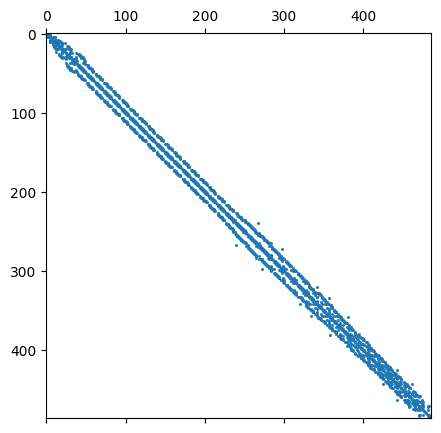

In [42]:
import scipy
import scipy.sparse
import matplotlib.pyplot as plt

i, j, v = problem.A.getValuesCSR()
fig = plt.figure(figsize=(5, 5), dpi=100)
A_scipy = scipy.sparse.csr_matrix((v, j, i))
ax = plt.spy(A_scipy, markersize=1.0)
plt.show()